In [2]:
import urllib,os
from netCDF4 import Dataset

download=False
the_file='case_60_10.nc'
the_url="http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/{}".format(the_file)
if download:
    out=urllib.request.urlretrieve(the_url,the_file)
    print(out)
print("download {}: size is {:8.4g} Mbytes".format(the_file,os.path.getsize(the_file)*1.e-6))

download case_60_10.nc: size is    499.3 Mbytes


In [3]:
!ncdump -h case_60_10.nc

netcdf case_60_10 {
dimensions:
	time = 48 ;
	x = 25 ;
	y = 20 ;
	z = 130 ;
variables:
	float time(time) ;
		string time:units = "minutes" ;
	float x(x) ;
		string x:units = "meters" ;
	float y(y) ;
		string y:units = "meters" ;
	float z(z) ;
		string z:units = "meters" ;
	float press(z) ;
		string press:units = "Pa" ;

// global attributes:
		:heat_flux_W_m2 = 100L ;
		:gamma_K_km = 10L ;

group: c1 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c1

group: c2 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c2

group: c3 {
  variables:
  	float TABS(time, z, y, x) ;
  

Netcdf file layout:  10 groups corresponding to 10 different ensemble members.  Small slice of larger domain of LES run with surface heat flux of 60 W/m^2 and stable layer with dT/dz = 10 K/km.  Snapshots every 10 minutes for 8 hours.

[ 100.  200.  300.  325.  375.  400.  425.  490.  525.  560.  640.  665.
  605.  690.  755.  685.]


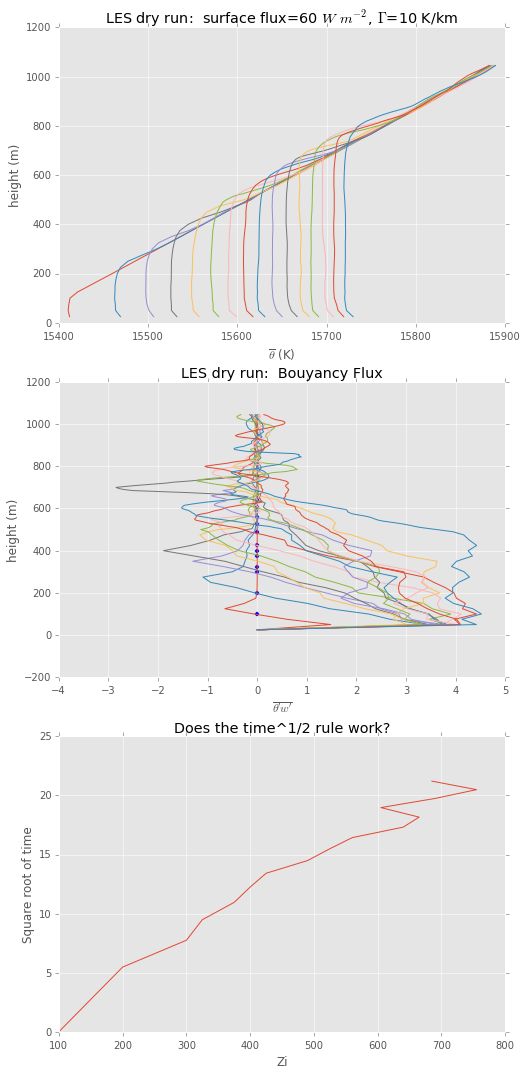

In [64]:
from matplotlib import pyplot as plt
import numpy as np
% matplotlib inline
def make_theta(temp,press,W_pert,temp_pert):
    """
      temp in K
      press in Pa
      returns theta in K
    """
    p0=1.e5
    Rd=287.
    cpd=1004.
    term1=(p0/press)**(Rd/cpd)
    term1=term1[np.newaxis,:]
    theta=temp*term1
    term1=term1[:,:,np.newaxis,np.newaxis]
    theta_pert = temp_pert*term1
    Bf = theta_pert*W_pert
    Bf=Bf.mean(axis=3).mean(axis=2)
    return (theta,Bf)

    
case_name='case_60_10.nc'
for grp in range (1,11):
    ensemble='c' + str(grp)

    with Dataset(case_name,'r') as ncin:
        group = ncin.groups[ensemble]
        temp=group.variables['TABS'][...]
        W=group.variables['W'][...]
        press=ncin.variables['press'][...]
        z=ncin.variables['z'][...]
    temp_m=temp.mean(axis=3).mean(axis=2)
    temp_pert=temp-temp_m[:,:,np.newaxis,np.newaxis]
    W_m = W.mean(axis=3).mean(axis=2)
    W_pert = W - W_m[:,:,np.newaxis,np.newaxis]
    theta,Bf = make_theta(temp_m,press,W_pert,temp_pert)
    if ensemble == 'c1':
        theta_av = theta
        Bf_av = Bf
    else:
        theta_av+=theta_av
        Bf_av+=Bf_av
theta_av/=10
Bf_av/=10
ct = 0
zi = np.zeros(temp.shape[0]/3)
Time = np.zeros(temp.shape[0]/3)
plt.style.use('ggplot')
fig,ax=plt.subplots(3,1,figsize=(8,18))
for i in np.arange(0,temp.shape[0],3):
    Time[ct] = ct*30
    ax[0].plot(theta_av[i,:],z)
    ax[1].plot(Bf_av[i,:],z)
    minn = np.argmin(Bf_av[i,:])
    x = np.where(Bf_av[i,:]<0)
    zi[ct] = x[0][0]
    zi[ct] = z[zi[ct]]
    ax[1].scatter(0,zi[ct])
    ct += 1
ax[2].plot(zi,Time**.5)

out=ax[2].set(xlabel=r"Zi",ylabel='Square root of time',
           title='Does the time^1/2 rule work?')

out=ax[1].set(xlabel=r"$\overline{\theta'w'}$",ylabel='height (m)',
           title='LES dry run:  Bouyancy Flux')

out=ax[0].set(xlabel=r'$\overline{\theta}$ (K)',ylabel='height (m)',
           title='LES dry run:  surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km')

print (zi)


# It appears to preform relatively well, but does not hold perfectly true.

## The scatter increase later in the run.

# Mixed layer

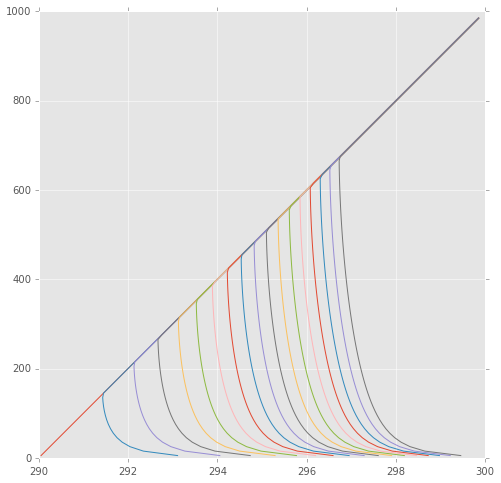

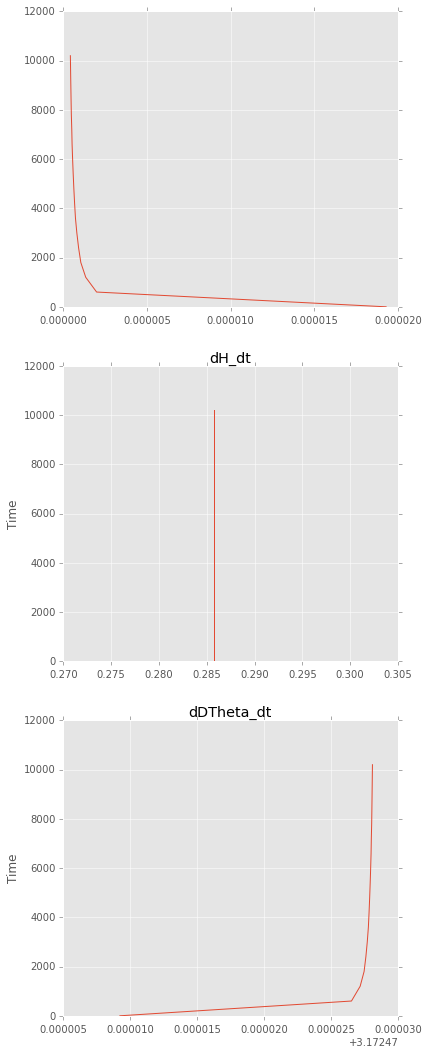

In [88]:
import numpy as np
import pdb
import scipy.integrate as integrate
from matplotlib import pyplot as plt
import scipy.special as spec

#from Bretherton UW547

def dthdt(theta, t, zf, zh, l, Fth0):
    """
    Fth=np.empty_like(zf)
    g = 9.8
    thetaref = np.mean(theta)
    dthdz = np.diff(theta)/np.diff(zh)


    dbdz = (g/thetaref)*dthdz
    dbdz[dbdz>0] = 0
    K = l**2.*np.sqrt(-16*dbdz)
    Fth[1:-1] = -K*dthdz
    Fth[0] = Fth0
    Fth[-1] = 0
    tend = -np.diff(Fth)/np.diff(zf)
#    pdb.set_trace()
    return tend


import numpy as np

if __name__ == "__main__":
    tf = 3*3600
    dtout = 600
    dz = 10.
    ztop = 1000.
    the_lambda = 100.
    Hs0 = 300.
    zh = np.arange(dz/2,(ztop-dz/2),dz)
    thetai = 290 + 0.01*zh

    tspan = np.arange(0.,tf,dtout)
    zf = np.arange(0.,ztop,dz)
    nz = len(zh)

    rhoref = 1.2
    Cp = 1004.
    Fth0 = Hs0/(rhoref*Cp)

    k = 0.4
    l = the_lambda/(1 + the_lambda/(k*zf[1:-1]))

    the_prof=integrate.odeint(dthdt, thetai, tspan,(zf, zh, l, Fth0))
    plt.close('all')
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    h = the_prof.shape
    height = np.zeros(shape = (h[0]))
    idx = 0
    for item in the_prof:
        ax.plot(item,zh)
        z = np.argmin(item)
        height[idx] = zh[z] + 10    ###### adding 10 m as per the bit after eq 15
        idx+=1
    dTheta_dt = (1+k)*Fth0/(height*Cp*rhoref)   #### Couldnt find a deff for rho_*
    wh = .002       #### seting wh to ~ a few cm/s as per the bit after eq 19 ... since we dno't have w
    dH_dt = (k*Fth0)/(rhoref*Cp*(dTheta_dt*height))
    dDTheta_dt = spec.gamma(dH_dt - wh) - dTheta_dt
    plt.show()
    fig,ax = plt.subplots(3,1,figsize = (6,18))
    ax[0].plot(dTheta_dt,tspan)
    ax[1].plot(dH_dt,tspan)
    ax[2].plot(dDTheta_dt,tspan)
    
    out=ax[2].set(ylabel='Time',
               title='dTheta_dt')

    out=ax[1].set(ylabel='Time',
               title='dH_dt')

    out=ax[2].set(ylabel='Time',
               title='dDTheta_dt')


### I'm pretty sure these are wrong, but I coulnd't find a deffintion for rho-star, we don't have w so I just chose an arbitrarily small number for wh, and I don't think I used the gamma function propperly in eq 13